# Detecting numbers on a picture 
## Using a CNN Network trained with MNIST data
Images like this are our input:
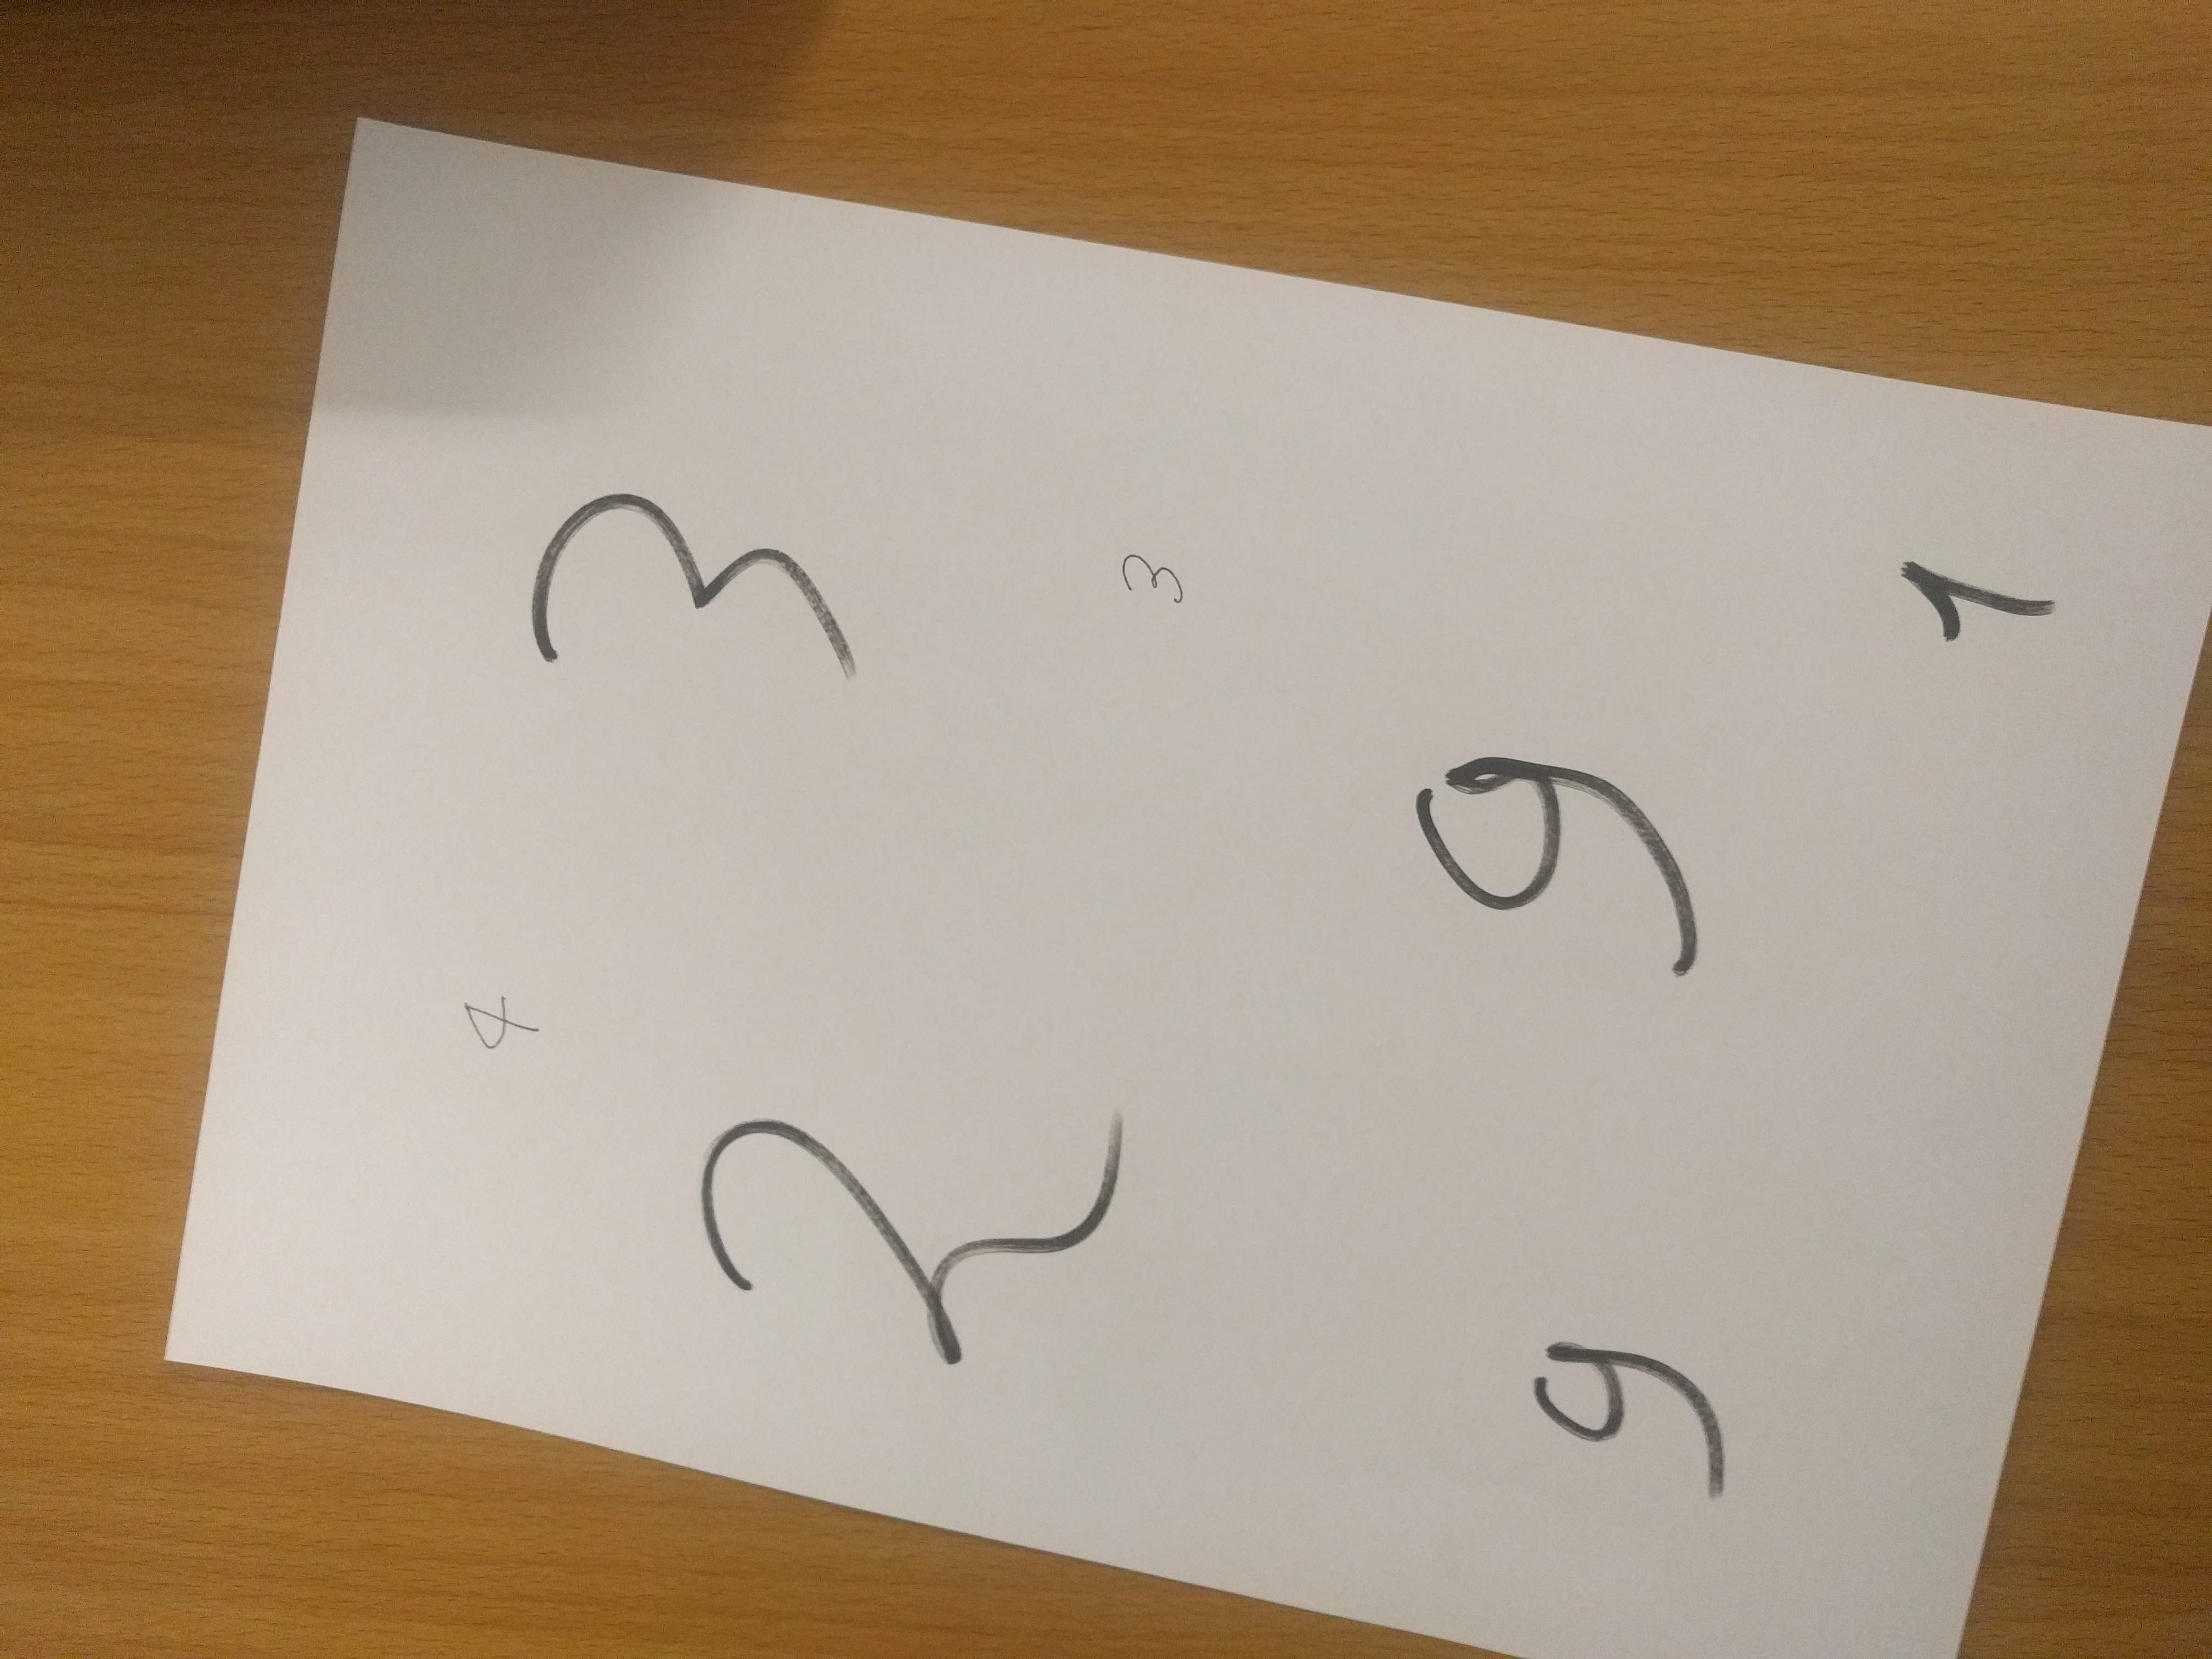

## Loading the packages

In [1]:
import numpy as np
from matplotlib import pyplot as plt

# ... import here the different keras libraries you need
from keras.datasets import mnist
from keras.utils import to_categorical

#other libs
from sklearn import metrics as me

%matplotlib inline

import skimage.data
from skimage.io import imread_collection
import skimage.feature
import skimage.transform.hough_transform as ht

import matplotlib.patches as patches
import skimage.measure

Using TensorFlow backend.


----------------------------------------------------------------------------------------------------------
## Click this link to jump to the [Main](#Main) Cell ! you're welcome
Since the cells below only define the functions called in main.
The CNN model is loaded from a saved file. If you want to retrain the model see the cells below the Main cell.

----------------------------------------------------------------------------------------------------------

## Load Weights and model:  -  jump to [Main](#Main)

In [2]:
def load_model():
    from keras.models import load_model
    model = load_model('MNIST_V1_small_model.h5')
    print("\n---   CNN Model loaded from file 'MNIST_V1_small_model.h5'   ---\n")
    return model

Comment: works well

## Image Preprocessing  -  jump to [Main](#Main)

In [3]:
def preprocess_images(path):
    #creating a collection with the available images
    col = imread_collection(path)
    print("%s images were loaded\n" %(len(col)))

    collection = []
    for im in col:
        if im.shape[0] == 3024:
            print(im.shape," rotated to: ", np.rot90(np.rot90(np.rot90(im))).shape)
            im = np.rot90(np.rot90(np.rot90(im)))
        else:
            print(im.shape)
        collection.append(im)

    print("the images have the shape: ",collection[0].shape)
    return collection

Comment: I read all pictures in the location and rotate the ones necessary. This solution is not very generalizable, meaning for other pictures you'd have to rewrite this function. Maybe a better solution would have been to just reshape each image to AxB pixels, but that may have deformed the numbers.

## Choose single Image  -  jump to [Main](#Main)

In [4]:
def choose_image(choose_image, collection):
    collection_in_gray = [im[:,:,0] for im in collection]
    print("\nWe will only select one image to perform my algorithm.")

    img = collection_in_gray[choose_image]
    print("You have chosen img %s (in the Main cell)\n"%(choose_image))
    return img

Comment: running a loop over all pictures is quite demanding, numerus lists and stacked arrays make this difficult, so I'm just taking one picture.

## Edge detection  -  jump to [Main](#Main)

In [5]:
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)

def edge_detection(img):
    canny_low_threshold= 0.02 #(0.00,0.4) good value: 0.02
    canny_high_threshold= 0.15 #(0.00,0.4) good value: 0.15
    canny_sigma =  6 #                      good value: 6        <-- TWEAK HERE
    n_best_lines = 8

    print("performin Canny Edge detection..")
    imedges = skimage.feature.canny(skimage.img_as_float(img),
                                    low_threshold=canny_low_threshold,
                                    high_threshold=canny_high_threshold,
                                    sigma=canny_sigma
                                   )
    print("done.")

    H,angles,distances = ht.hough_line(imedges)


    # Remove all votes for lines that do not have a compatible angle with the one we are looking for
    H_filtered = H.copy()
    angle_thresh = 35   #Threshold for allowed angles
    angles_compatible = (((angles > np.deg2rad(0-angle_thresh)) &  (angles < np.deg2rad(0+angle_thresh))) 
                         |
                         ((angles > np.deg2rad(90-angle_thresh)) & (angles < np.deg2rad(90+angle_thresh)))
                         |
                         ((angles > np.deg2rad(-90-angle_thresh)) & (angles < np.deg2rad(-90+angle_thresh))))

    H_filtered[:,~angles_compatible] = 0

    fig,(ax0,ax1) = plt.subplots(ncols=2, nrows=1, figsize=(17,15))
    ax0.imshow(img, cmap="gray")
    ax0.set_title("Detected lines")
    ax1.imshow(imedges, cmap="gray")
    ax1.set_title("Canny images with detected lines")

    ind = largest_indices(H_filtered, n_best_lines)
    lines=[]
    anglelist=[]

    for i in range(n_best_lines):
        maxr = ind[0][i]
        maxc = ind[1][i]
        d = distances[maxr]
        theta = angles[maxc]
        anglelist.append(theta)

        ## Now we want to draw the line in image space
        # This is one point on the line
        p1 = np.array([d*np.cos(theta), d*np.sin(theta)])
        # This is the unit vector pointing in the direction of the line (remember what theta means in Hough space!)
        linedir = np.array([np.cos(theta+np.pi/2), np.sin(theta+np.pi/2)])
        # These are two points very far away in two opposite directions along the line

        p0 = p1 - linedir * 5000
        p2 = p1 + linedir * 5000
        lines.append([[p0[0],p0[1]],[p2[0],p2[1]]])
        # We now draw a line through p0 and p2, without rescaling the axes.
        ax0.plot([p0[0],p2[0]],[p0[1],p2[1]], scalex=False, scaley=False)
        ax1.plot([p0[0],p2[0]],[p0[1],p2[1]], scalex=False, scaley=False)
    return lines

Comment: 
- Sigma=6 works well, since the A4 paper sheet is much brighter then the surounding, the high sigma blurs a lot and only the main edges remain.
- I chose the ht.hough_line command over the probabilistic one, and looking back this was a good choice. I only need the n longest lines (for this I needed the helper function at the top). Using ht.hough_line gives me angles, having those I can also filter the edges on a angle, like I do with: angle_thresh = 35. I enlargen the line directions detected with 'p0 = p1 - linedir * 5000' and add them to a list for the next 'corner detection' section.

works well, I look for the 10 best lines, and filter the corners found in the next section!

## Corner detection  -  jump to [Main](#Main)

In [6]:
def corner_detection(img, lines):
    corners=[]
    for i in range(len(lines)):
        for j in range(len(lines)):
            if j<=i:
                pass
            else:
                corners.append(findIntersect(lines[i],lines[j]))

    #only keep in the range of -1000 to +6000 on both axis
    corners_final = []
    for corner in corners:
        if (corner[0] > -1000) & (corner[0] < 6000) & (corner[1] > -1000) & (corner[1] < 6000):
            m=0
            for c in corners_final:  #check if a similar corner has allready been found, then don't append!!!
                if (corner[0] > c[0]-500) & (corner[0] < c[0]+500) & (corner[1] > c[1]-500) & (corner[1] < c[1]+500):
                    m=1
            if m==0:
                corners_final.append(corner)

    print("\nfrom initialy %s corners, %s are realistic! (We only keep corners in the range of -1000 to \
+6000, and filter those overlapping)\n" %(len(corners),len(corners_final)))
    plt.figure(figsize=(12,10))
    plt.imshow(img,
               vmin=0,   # value which maps to black
               vmax=255, # value which maps to white
               cmap="gray")

    for corner in corners_final:
        plt.plot(corner[0],corner[1], "or")
    return corners_final

def findIntersect(line1, line2): # Helper function from the web
    x1 = line1[0][0]
    y1 = line1[0][1]
    x2 = line1[1][0]
    y2 = line1[1][1]
    x3 = line2[0][0]
    y3 = line2[0][1]
    x4 = line2[1][0]
    y4 = line2[1][1]
    
    px= ( (x1*y2-y1*x2)*(x3-x4)-(x1-x2)*(x3*y4-y3*x4) ) / ( (x1-x2)*(y3-y4)-(y1-y2)*(x3-x4) ) 
    py= ( (x1*y2-y1*x2)*(y3-y4)-(y1-y2)*(x3*y4-y3*x4) ) / ( (x1-x2)*(y3-y4)-(y1-y2)*(x3-x4) )
    return [px, py]

comment: with the simple findIntersect function I find all corners. Then I filter those, if the intersection is way beyond the picture boundaries or if a similar corner has allready been found, then don't append.

## Transform projective  -  jump to [Main](#Main)

In [19]:
def transform_rectify(img, corners):
    transf_collection = []
    print("\ncalculating rectified images...")
    z=0.0
    A=[0,800] #src
    B=[1040,800]
    C=[1040,0]
    D=[0,0]
    
    for i in range(4):
        print(int(z/2.4),"% loaded")
        for j in range(4):
            print(".")
            for n in range(4):
                for m in range(4):
                    if i==j | m==n | i==n | i==m | j==n | j==m: pass #if two indices are the same don't transform
                    else:
                        z +=1
                        a=corners[i] #dst # corners[0]  for image 0 
                        b=corners[j]      # corners[1]
                        c=corners[m]      # corners[3]
                        d=corners[n]      # corners[2]

                        tf = skimage.transform.estimate_transform('projective', dst=np.vstack((a,b,c,d)), src=np.vstack((A,B,C,D)))
                        tfimage = skimage.transform.warp(img, tf, output_shape=(800,1040))  # output images shape = (200,260)
                        th_low=0.3
                        th_high=0.9
                        tf_mask_margin = 40
                        tfimage = tfimage[0+tf_mask_margin:800-tf_mask_margin, 0+tf_mask_margin:1040-tf_mask_margin]
                        # this margin will prevent detection of dark edges
                        if np.mean(tfimage) > th_low:
                            if np.mean(tfimage) < th_high:
                                transf_collection.append(tfimage)
                        
    print("done. %s transformations were performed. %s \
of them have a mean intensity between %s and %s\n" %(z,len(transf_collection),th_low,th_high))
    return transf_collection

Comment: 
- Here I try all possibel corner positions total 256 minus the ones that don't make sense, i.e. when two corners have the same index.
- then I allready filter impossible pictures out, like if the mean intensity is to low or high.
- also I want to crop edges with tf_mask_margin, so I don't have dark edge remainings that can be missdetected as numbers.

## Extract each number  -  jump to [Main](#Main)

In [28]:
def extract_numbers(transf_collection):
    im_coll=[]
    rects_list=[]
    transf_collection_filt = []
    i=0
    for img in transf_collection:
        mask = (img < 0.5)   # We need tha mask displayed below, to detect the white numbers for extraction
        labels = skimage.measure.label(mask)
        regions = skimage.measure.regionprops(labels)
        large_regions = [r for r in regions if (r.area > 20)&(r.area < 3000)] 

        rects=[]
        i_c = []
        for r in large_regions:
            (min_row, min_col, max_row, max_col) = r.bbox
            width = max_col - min_col
            height = max_row - min_row
            rect = patches.Rectangle((min_col,min_row),width,height,     # draws rectangles around  
                                     linewidth=1,edgecolor='b',facecolor='none')
            rects.append(rect)
            image = img[min_row:max_row,min_col:max_col]
            i_c.append(image)
        
        if (len(rects) > 3) & (len(rects) < 15):
            transf_collection_filt.append(transf_collection[i])
            im_coll.append(i_c)
            rects_list.append(rects)
            print(len(rects), " rects detected")
        i += 1
    print("We only take rectifications >3 but less then 15 rectangles. Number of transformed images left to assess:",len(transf_collection_filt))
    return (im_coll,rects_list,transf_collection_filt)

Comment:
- with label and regionprops I easily find the numbers in the pictures, filtering area size too.
- I only take possible rectifications, that have min 3 and max 9 rectangulars detected

## Predict - feed extracted images to CNN Network  -  jump to [Main](#Main)

In [29]:
def predict(img,model,im_coll,transf_collection,rects_list):
    #Preprocessing images:
    pred_list=[]
    X_predict_list=[]
    for image in im_coll:
        X_predict = []

        for im in image:
            im = skimage.transform.resize(im, (28,28))
            im = 1-im                      # Makes negatives, black-on-white to wh-on-blk !
            im = im/np.max(im)             #images will be darker than others, here we normalize
            im = (im >0.5)*im              #We want dark to be black and not gray, so mask all dark and make it black
            X_predict.append(im)

        X_predict = np.array(X_predict).reshape(len(image),28,28,1)
        pred = model.predict(X_predict)  # Predict on CNN model
        pred_list.append(np.max(pred))  # Here we add the mean of each prediction, so we can find the correct rectification
        print("max and mean of this prediction: ",np.round(np.max(pred),4),np.round(np.mean(pred),4))
        X_predict_list.append(X_predict)

    indices=np.argmax(pred_list)
    X_pred = X_predict_list[indices]
    tfimg = transf_collection[indices]

    pred2 = model.predict_classes(X_pred)

    print(X_pred.shape,  " Images loaded")
    print("Input shape should be nx28x28x1 and white writing on black! AND Pixel values 0...1, let's \n \
    print some pictures extracted from our paper for visualisation: ")

    fig,(ax0,ax1,ax2,ax3,ax4) = plt.subplots(ncols=5, nrows=1, figsize=(20,20))
    ax1.imshow(tfimg, vmin=0, vmax=1, cmap='gray')
    for rect in rects_list[indices]:
        ax1.add_patch(rect)
    ax1.set_title("The correctly rectified image out of 240")
    ax0.imshow(img, vmin=0, vmax=255, cmap='gray')
    ax0.set_title("original image")
    ax2.imshow((tfimg < 0.5), vmin=0, vmax=1, cmap='gray')
    ax2.set_title("mask")
    try:
        ax3.imshow(X_pred[1].reshape(28,28), vmin=0, vmax=1, cmap='gray')
        ax3.set_title("random detected number")
        ax4.imshow(X_pred[2].reshape(28,28), vmin=0, vmax=1, cmap='gray')
        ax4.set_title("random detected number")
        
    except:
        print("Error when plotting in 'def predict()'")

    return pred2

Comment
- first I preprcess the rectangles cut out in the previous step (see comments in code), then I choose the rectified image with the highes probability returned by the model.predict function.
- I chose to go with a sigmoid function as a last layer in my CNN model, since softmax allways adds up to 1, and I felt like that would prohibit me from also using a mean probabily if needed.

# Main

22 images were loaded

(3024, 4032, 3)  rotated to:  (4032, 3024, 3)
(4032, 3024, 3)
(4032, 3024, 3)
(4032, 3024, 3)
(4032, 3024, 3)
(4032, 3024, 3)
(4032, 3024, 3)
(3024, 4032, 3)  rotated to:  (4032, 3024, 3)
(3024, 4032, 3)  rotated to:  (4032, 3024, 3)
(4032, 3024, 3)
(3024, 4032, 3)  rotated to:  (4032, 3024, 3)
(4032, 3024, 3)
(4032, 3024, 3)
(4032, 3024, 3)
(4032, 3024, 3)
(3024, 4032, 3)  rotated to:  (4032, 3024, 3)
(3024, 4032, 3)  rotated to:  (4032, 3024, 3)
(3024, 4032, 3)  rotated to:  (4032, 3024, 3)
(4032, 3024, 3)
(4032, 3024, 3)
(3024, 4032, 3)  rotated to:  (4032, 3024, 3)
(4032, 3024, 3)
the images have the shape:  (4032, 3024, 3)

We will only select one image to perform my algorithm.
You have chosen img 0 (in the Main cell)

performin Canny Edge detection..
done.


C:\Users\steven.walker\Anaconda3\envs\new\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\steven.walker\Anaconda3\envs\new\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in double_scalars



from initialy 28 corners, 4 are realistic! (We only keep corners in the range of -1000 to +6000, and filter those overlapping)


calculating rectified images...
0 % loaded
.
.
.
.
26 % loaded
.
.
.
.
51 % loaded
.
.
.
.
77 % loaded
.
.
.
.
done. 240.0 transformations were performed. 141 of them have a mean intensity between 0.3 and 0.9

6  rects detected
6  rects detected
6  rects detected
6  rects detected
4  rects detected
6  rects detected
10  rects detected
4  rects detected
6  rects detected
10  rects detected
6  rects detected
6  rects detected
6  rects detected
We only take rectifications >3 but less then 9 rectangles. Number of transformed images left to assess: 13

---   CNN Model loaded from file 'MNIST_V1_small_model.h5'   ---

max and mean of this prediction:  0.8482 0.0151
max and mean of this prediction:  0.2984 0.0052
max and mean of this prediction:  0.0092 0.0003
max and mean of this prediction:  0.0603 0.0012
max and mean of this prediction:  0.068 0.0082
max and mea

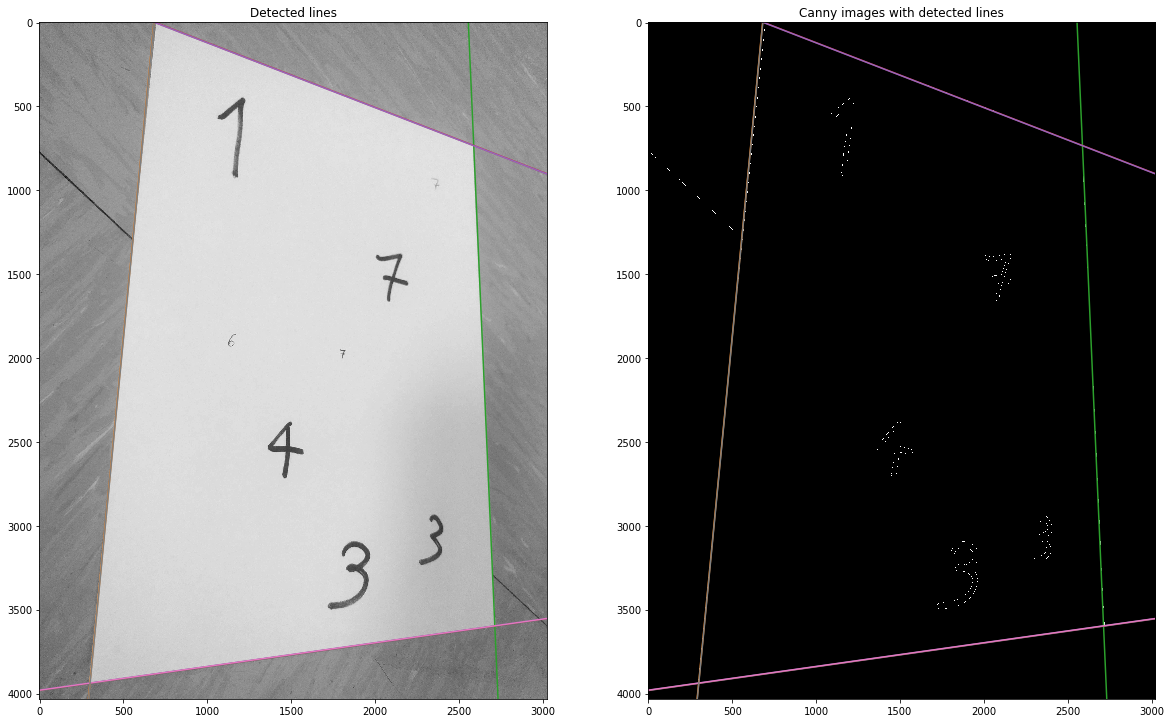

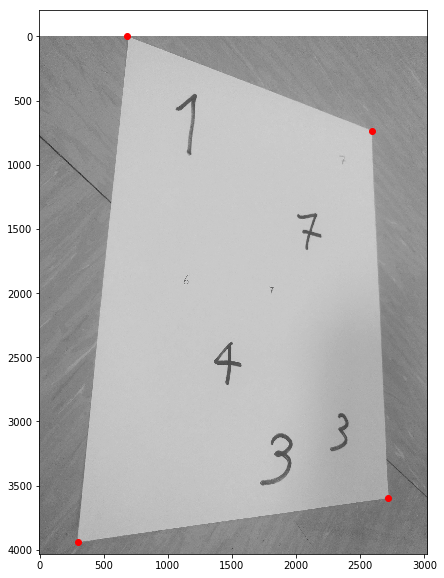

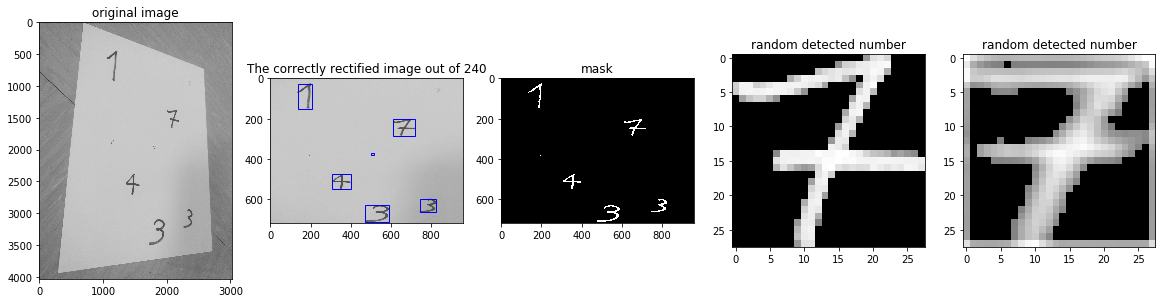

In [30]:
# Choose path where homework pictures are located.
path = 'homework_images_vol_1/*.jpg'
collection = preprocess_images(path)

#Choose a image to process:
image_nr = 0
img = choose_image(image_nr, collection)
lines_list = edge_detection(img)
corners = corner_detection(img, lines_list)
transf_collection = transform_rectify(img, corners)

im_coll, rects_list, transf_collection_filt = extract_numbers(transf_collection)
model = load_model()    # load CNN MNIST trained network

predict_classes = predict(img, model, im_coll, transf_collection_filt, rects_list)

print("\nOUR PREDICTION: (done with a MNIST trained CNN model with sigmoid output layer for probabilities) ",predict_classes)

# <font color='red'> If Model has to be trained again, execute cells below </font>

## Loading the raw data
Keras provides easy access to different datasets including MNIST. First load the `mnist` dataset and normalize it to be in the range [0, 1]

(60000, 28, 28, 1) with:  60000 train samples
(10000, 28, 28, 1) with:  10000 test samples


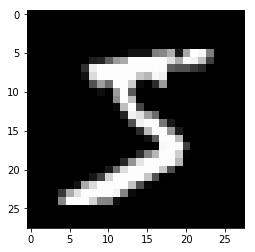

In [71]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000,28,28,1) #for the model we add a invisible last 'grey' dimension
X_test = X_test.reshape(10000,28,28,1) #for the model we add a invisible last 'grey' dimension

X_train =  X_train.astype('float32')# change the type towards float32
X_test =   X_test.astype('float32')# idem
X_train /= 255.0 # normalize the range to be between 0.0 and 1.0
X_test /=  255.0
print(X_train.shape, "with: ",X_train.shape[0], 'train samples')
print(X_test.shape, "with: ",X_test.shape[0], 'test samples')

plt.imshow(X_train[0].reshape(28,28), cmap='gray')

The target values of the network are supposed to be 1-hot targets. Now the `y_train` is an array with scalar values as in `[5 0 4 1 ...]` and it should be a 1-hot array `Y_train` as in : 

`[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]...]`
 
Note the change of capital letter in the `Y_train` to denote, per convention, an array with multiple dimensions.

In [55]:
n_classes = 10
Y_train = to_categorical(y_train, n_classes)# modify targets to 1-hot using np_utils.to_categorical()
Y_test = to_categorical(y_test, n_classes)# idem 
print(Y_train[:10])

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


## Define the network <font color='red'> --> If model is allready saved, jump to 'load model' </font>

In [56]:
from keras import backend as K

# for the architecture
from keras.models import Sequential
from keras.layers import Dense, Dropout, Lambda, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, AvgPool2D

# optimizer, data generator and learning rate reductor
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [57]:
H = 300               # number of neurons
E = 10                # number of epochs
B = 128               # batch size

model = Sequential()

dim = 28
nclasses = 10

model.add(Conv2D(filters=12, kernel_size=(5,5), padding='same', activation='relu', input_shape=(dim,dim,1))) # 32 Filter, 5x5 Kernel
model.add(Conv2D(filters=12, kernel_size=(3,3), padding='same', activation='relu',)) # 32 Filter, 5x5 Kernel
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=42, kernel_size=(5,5), padding='same', activation='relu')) # 64 Filter, 5x5 Kernel
model.add(Conv2D(filters=42, kernel_size=(3,3), padding='same', activation='relu')) # 64 Filter, 5x5 Kernel
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(nclasses, activation='sigmoid'))


In [58]:
model.summary()   # ... print model infomration with summary() method

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 12)        312       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 12)        1308      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 12)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 12)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 42)        12642     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 42)        15918     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 42)          0         
__________

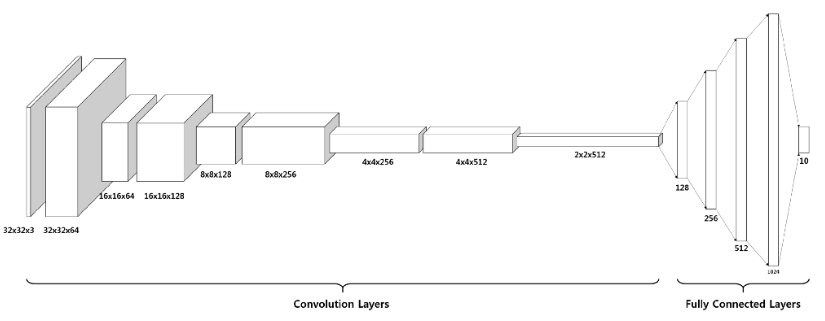

### Compile and train the network - <font color='red'> !! Use load function further below to save time !! </font>
In Keras, we call the methods `compile()` and `fit()`. For the compile phase, we need to specify the **loss** function which should be set in the case of multi-class classification to `categorical_crossentropy`. We also need to specify the optimizer strategy. In this case the `rmsprop` or `adam` can be used.

In [60]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy']) # compile the model with a crossentropy loss, rmsprop optimizer 
#      and defining metrics to be stored as history of the training

log = model.fit(X_train,Y_train,batch_size=B,epochs=E,verbose=1,validation_data=(X_test,Y_test))
# call the training with the fit() function giving the tensors as 
# inputs, defining batch size, number of epochs and validation data


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 296s 5ms/step - loss: 0.2787 - acc: 0.9130 - val_loss: 0.0583 - val_acc: 0.9805
Epoch 2/10
60000/60000 [==============================] - 283s 5ms/step - loss: 0.0747 - acc: 0.9773 - val_loss: 0.0415 - val_acc: 0.9867
Epoch 3/10
60000/60000 [==============================] - 284s 5ms/step - loss: 0.0554 - acc: 0.9826 - val_loss: 0.0341 - val_acc: 0.9890
Epoch 4/10
60000/60000 [==============================] - 281s 5ms/step - loss: 0.0435 - acc: 0.9861 - val_loss: 0.0298 - val_acc: 0.9891
Epoch 5/10
60000/60000 [==============================] - 564s 9ms/step - loss: 0.0364 - acc: 0.9886 - val_loss: 0.0276 - val_acc: 0.9907
Epoch 6/10
31872/60000 [==============>...............] - ETA: 2:34 - loss: 0.0308 - acc: 0.9901

KeyboardInterrupt: 

### Save model and weights

In [61]:
model.save('MNIST_V1_small_model.h5')
'''This save function saves:

-The architecture of the model, allowing to re-create the model.
-The weights of the model.
-The training configuration (loss, optimizer).
-The state of the optimizer, allowing to resume training exactly where you left off.'''

model.save_weights('backup_weights.h5') #this just saves the weights, used as emergency backup here

### Evaluate the network

We can do this at three levels: (1) plot of the loss during the training phase, (2) overall accuracy evaluation on test set and (3) per class evaluation with confusion matrix on test set.

### Loss evolution during training
This can be done first looking at the history of the training (output of the `fit()` function).

In [62]:
try:
    plt.plot(log.history['loss'], label='Training')
    plt.plot(log.history['val_loss'], label='Testing')
    plt.legend()
    plt.grid()
except:
    print("--> only works if model was completely trained in this run, and wasn't loaded from the saved model")

--> only works if model was trained in this run, and wasn't loaded from the saved model


### Model evaluation -> Optional
We can compute the overall performance on test set calling the `evaluate()` function on the model. The function returns the loss and the metrics used to compile the models.

In [63]:
loss_test, metric_test = model.evaluate(X_test,Y_test,verbose=1) # ... evaluate model performance on test set

print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

pred = model.predict_classes(X_test, verbose=1)
me.confusion_matrix(y_test, pred)

10000/10000 [==============================] - 34s 3ms/step
Test loss: 0.022556390739703783
Test accuracy: 0.9926
10000/10000 [==============================] - 36s 4ms/step


array([[ 976,    0,    0,    0,    0,    1,    0,    0,    3,    0],
       [   0, 1133,    0,    1,    0,    0,    1,    0,    0,    0],
       [   1,    1, 1026,    1,    1,    0,    0,    2,    0,    0],
       [   0,    0,    0, 1007,    0,    1,    0,    0,    1,    1],
       [   0,    0,    1,    0,  976,    0,    0,    0,    0,    5],
       [   0,    0,    0,    6,    0,  885,    0,    0,    0,    1],
       [   5,    2,    0,    1,    2,    5,  943,    0,    0,    0],
       [   0,    3,    8,    1,    0,    0,    0, 1011,    1,    4],
       [   0,    1,    1,    2,    2,    1,    0,    0,  966,    1],
       [   0,    0,    0,    0,    3,    0,    0,    2,    1, 1003]],
      dtype=int64)